The use of [Table of Contents (2)](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html) extension, or jupyterlabs built in table of contents is highly recommended :)

In [10]:
# Before importing libraries make sure you have these packages with the right version installed
# !pip install decorator==5.0.9
# !pip install networkx==3.*

In [1]:
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Basic graph concepts with networkx

### Adding nodes and edges



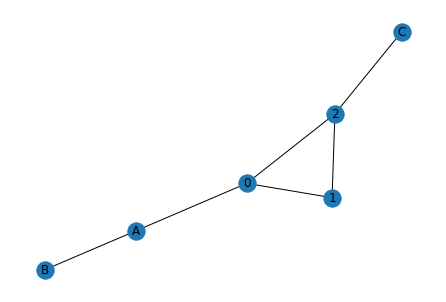

In [2]:
G = nx.Graph()

G.add_node('A')
G.add_nodes_from(['B', 'C'])

G.add_edge('A', 'B')
# note that adding edges will also add the necessary nodes
G.add_edges_from([(0,1), (1,2), (2,0)])
G.add_edges_from([('A',0), ('C',2)])

# save layout for future plots
layout = nx.spring_layout(G)
nx.draw(G, pos=layout, labels=None)

### Shortest paths

Two important attributes related to the shortest path are:
- **Average shortest path length**: as the name suggests
- **Diameter**: the maximal shortest path length

Average shortest path length: 1.9333333333333333
Diameter:                     4


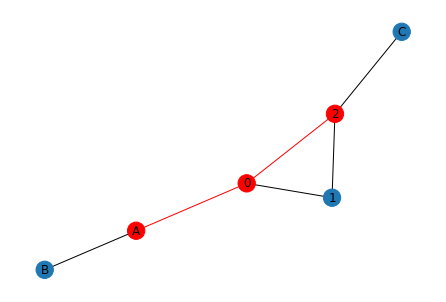

In [3]:
print(f'Average shortest path length: {nx.average_shortest_path_length(G)}')
print(f'Diameter:                     {nx.diameter(G)}')

shortest_path = nx.shortest_path(G, 'A', 2)
nx.draw(G, pos=layout, labels=None,
        node_color=['red' if (node in shortest_path) else 'tab:blue'
                    for node in G.nodes],
        edge_color=['red' if (src in shortest_path and tgt in shortest_path) else 'black'
                    for src, tgt in G.edges]
       )

plt.show()

### Neighbors, adjacency matrix

The adjacency matrix $A$ of a network contains the edge relations, such that $A_{ij} = 1$ if there is an edge between $i$ and $j$, $0$ otherwise. For undirected graphs this is a simmetric matrix. Interesting property of the adjacency matrix is that when it multiplies a vector it `propagates` the values to neighbors (see example below).

Neighbors (nx.neighbors): [1, 0, 'C']
Neighbors (adj. matrix): ['C' '0' '1']
Adjacency matrix:
[[0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0.]]


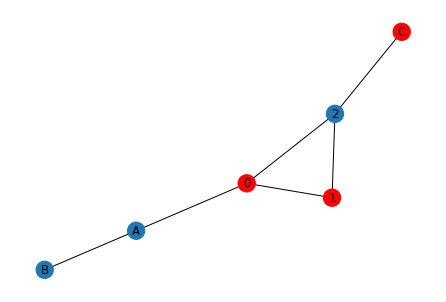

In [4]:
src_node = 2

# getting neighbors with networkx
neighbors = list(nx.neighbors(G, src_node))

# getting neighbors with adj. matrix
nodes = ['A', 'B', 'C', 0, 1, 2]
adj_mtx = nx.to_numpy_array(G, nodes)
src_node_indicator = np.array([node == src_node for node in nodes])
neighbor_indicator = adj_mtx.dot(src_node_indicator)

adj_mtx_neighbors = np.array(nodes)[neighbor_indicator > 0]

print(f'Neighbors (nx.neighbors): {neighbors}')
print(f'Neighbors (adj. matrix): {adj_mtx_neighbors}')
print('Adjacency matrix:')
print(adj_mtx)

nx.draw(G, pos=layout, labels=None,
        node_color=['red' if (node in neighbors) else 'tab:blue'
                    for node in G.nodes]
       )

plt.show()

### Centralities

Centralities refer to the importance of nodes/edges with respect to some measure. Centralities are usually normed, and take values between 0 and 1, but not necessarily. A few important examples are:
- **Degree**: (proportionate to) the number of edges connected to the node.
- **Closeness**: (proportionate to) the average shortest path length starting from the node to the rest of the network.
- **Betweenness**: (proportionate to) the number of shortest paths going through a node/edge.
- **Eigenvector**: (proportionate to) the stationary distribution of random walkers on the graph (i.e. the probability of finding a random walker on the node after a long time)

In [5]:
def draw_centrality(G, node_centrality, node_size=2000,
                    edge_centrality=None, edge_width=1,
                    cmap='Reds', font_color='white',
                    **kwargs):
    
    node_values = np.array([node_centrality[node] for node in G.nodes])
    if edge_centrality is None:
        edge_values = np.array([1 for edge in G.edges])
    else:
        edge_values = np.array([edge_centrality[edge] for edge in G.edges])
        
    nx.draw(G, font_color=font_color,
            labels={node: np.round(node_centrality[node], 2) for node in G.nodes},
            node_size=node_size * node_values,
            node_color=node_values,
            width=edge_width * edge_values,
            vmin=np.min(node_values) - 0.3 * (np.max(node_values) - np.min(node_values)), # shift the bottom of the colormap so labels are visible
            cmap=cmap,
            **kwargs
           )

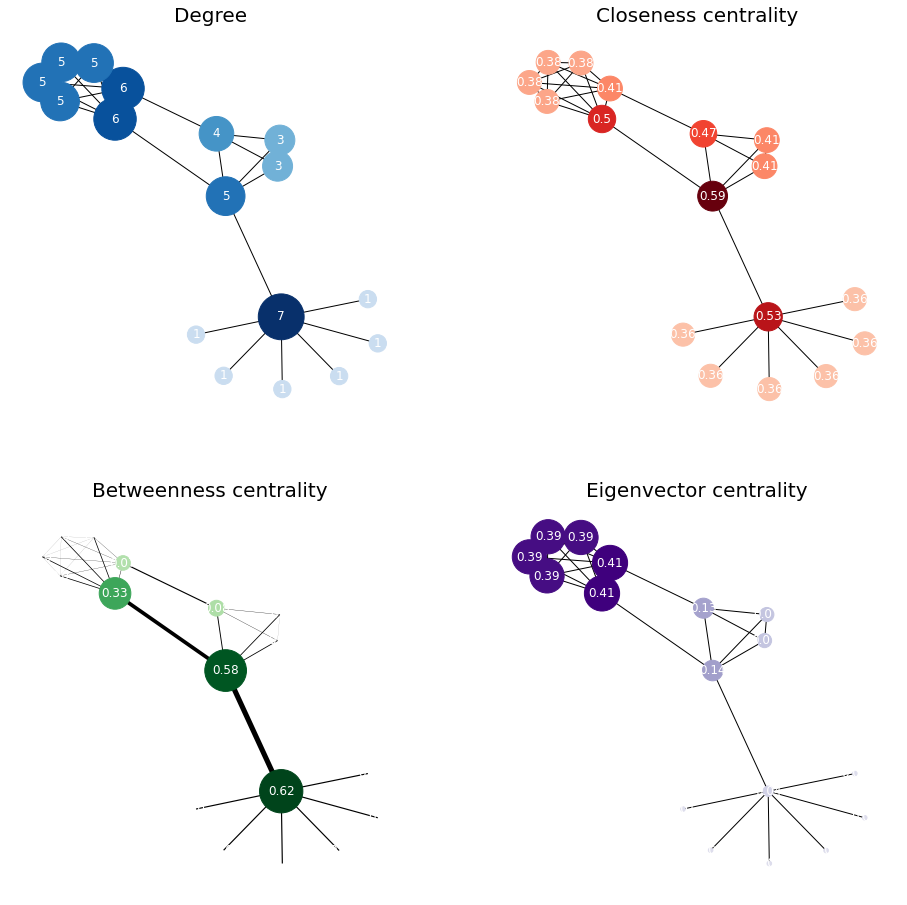

In [6]:
# create example graph
G = nx.compose(nx.compose(nx.complete_graph(range(4)), 
                          nx.complete_graph(range(4,10))),
                          nx.star_graph(range(10,17)))
               
G.add_edge(3,4)
G.add_edge(2,6)
G.add_edge(3,10)

# save layout for plots
layout = nx.spring_layout(G)


fig, axs = plt.subplots(2,2, figsize=(16,16))
# remove axis borders
for ax in axs.ravel():
    ax.axis('off')


ax = axs[0,0]
ax.set_title('Degree', fontsize=20)
draw_centrality(G, G.degree(), 
                pos=layout, ax=ax,
                node_size=300, cmap='Blues')

ax = axs[0,1]
ax.set_title('Closeness centrality', fontsize=20)
draw_centrality(G, nx.closeness_centrality(G),
                pos=layout, ax=ax,
                node_size=1500, cmap='Reds')

ax = axs[1,0]
ax.set_title('Betweenness centrality', fontsize=20)
draw_centrality(G, nx.betweenness_centrality(G), 
                pos=layout, ax=ax,
                node_size=3000, cmap='Greens', 
                edge_centrality=nx.edge_betweenness_centrality(G), edge_width=10)

ax = axs[1,1]
ax.set_title('Eigenvector centrality', fontsize=20)
draw_centrality(G, nx.eigenvector_centrality(G), 
                node_size=3000, cmap='Purples', 
                pos=layout, ax=ax)

plt.show()

### Communities

Communities are very important concept in network science (and an active research field). They usually refer to  densely connected regions of the graph. The most widely used measure for a given community partition of the network is **modularity**, which compares the observed fraction of links inside modules to a null model (usually configuration model):

$$ Q = \frac{1}{2M} \sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2M} \right] \delta_{c_i c_j} $$

where $M$ is the number of edges, $A$ is the adjacency matrix, $k_i$ is the degree and $c_i$ the community label of node $i$, and $\delta_{ij}$ the Kronecker-delta.

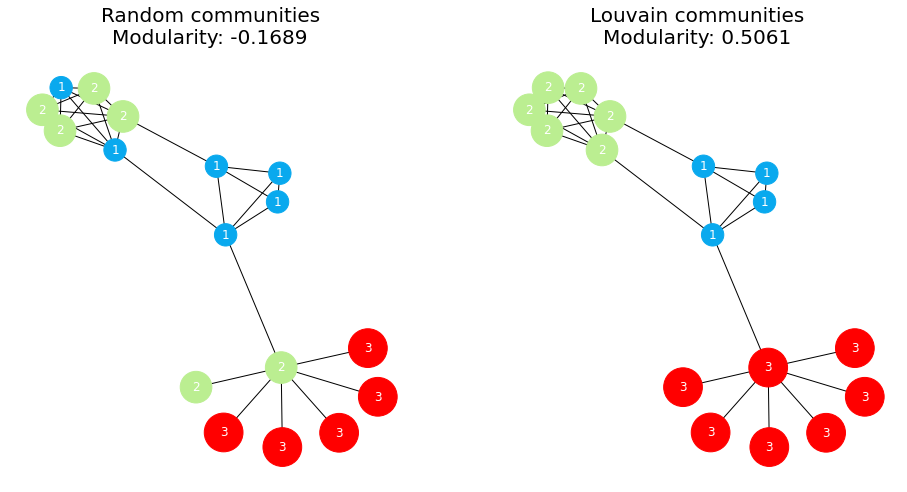

In [9]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

## random partition
communities=[[], [], []]
for node in G.nodes:
    communities[np.random.randint(3)].append(node)
    
axs[0].set_title(f'Random communities\nModularity: {nx_comm.modularity(G, communities):.4f}', fontsize=20)
draw_centrality(G, np.array([i+1 for i, comm in enumerate(communities) for node in comm]), 
                pos=layout, 
                node_size=500, cmap='rainbow',
                ax=axs[0])


communities = nx_comm.louvain_communities(G)
axs[1].set_title(f'Louvain communities\nModularity: {nx_comm.modularity(G, communities):.4f}', fontsize=20)
draw_centrality(G, np.array([i+1 for i, comm in enumerate(communities) for node in comm]), 
                pos=layout, 
                node_size=500, cmap='rainbow',
                ax=axs[1])

# Task 1. Zachary's karate club

A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate.

**a) Load data into a Graph object from the edgelist** ``data/zachary-karate.csv`` **using networkx**

**b) Identify "John A" and "Mr. Hi" using appropriate centrality measures. Create a meaningful visualization.**

**c) Partition the graph iteratively using the Girvan-Newman algorithm. Visualize how the modularity changes as the number of communities grow. Visualize the community structure corresponding to maximal modularity.**
This method relies on the betweenness being high on edges connecting denser sub-regions. It iteratively removes the single edge with the highest betweenness (or the most valuable edge by some other metric), until the graph falls into 2, giving the first 2 communities. The procedure is continued until there are no edges left, i.e. every node is in its own community. Thankfully networkx wraps this procedure in a nice iterator.

**d) Originally Zachary used the 'minimum cut' partitioning between "John A" and "Mr. Hi", and classified all members correctly (except one). How do these results compare to the previous excercise?**
Note that using the highest modularity partitioning doesn't always correspond to the best group structure for the given problem.

**BONUS**

**e) Create randomized counterparts for this graph using the configuration model. What changes compared to the original (regarding graph attributes, centrality measures or the optimal partitioning) and why?**
Creating randomized graphs while keeping key attributes of the original (e.g. the degrees in the configuration model) can help determine which characteristics are outstanding for such network. Comparing the original to the distribution of the randomized counterparts highlights unlikely structures which should not emerge randomly.\
Beware that the configuration model in networkx may create self-loops and multi-edges, which should not be possible in the original graph. Either discard them, or use the 'double-edge swap' approach (with the corresponding networkx function), where edges are iteratively swapped until the graph is sufficiently randomized (~10 times the number of edges swaps should be enough).

# Task 2. Random graph models

Random graph models aim to create graphs with well understood generation processes. By comparing real world networks to the ones generated by these models one might infer the rules behind their formation. 

**a) Create Erdős-Rényi random graphs of 10000 nodes and varying probability of connection (or number of edges). Plot how the degree distribution changes.**
The Erdős-Rényi model was the first and most basic random graph model: each of the $N$ nodes are connected with probability $p$ (or alternatively distribute $M$ edges between $N$ nodes, $p=\frac{2M}{N(N-1)}$). Most real world networks have significantly different structure (e.g. in degree distribution, clustering, group structure, but it still captures the "small-world" property).\
Note that the graph will consist of many separate subgaphs, unless $p \ge 1/N$ (or $M \ge N$).

**b) Create Barabási-Albert random graphs of 10000 nodes with varying number of edges for new nodes. Plot how the degree distribution changes.**
The Barabási-Albert model is also known as preferential attachement. This network is iteratively grown by adding $N$ nodes one-by-one, each with $m$ new edge, which are connected to existing nodes preferentially: nodes with higher degree have proportionally higher chance of receiving a new edge. This leads to the "rich get richer" phenomena, where most nodes have low degrees, but a few hubs have really high. Interestingly this type of structure is much better suited to describe real world graphs, like the internet (both physical connections and virtual links), or social networks.\
When visualizing the degree distribution it is also worth using "log-log" plots (where powerlaws become linear).

**c) Generate graphs with similar number of nodes and edges to Zachary's karate club using both models. Which degree distribution is closer to the original?**

# Task 3. Large graph visualization  (academic collaboration)

**a) Load data into a Graph object from ``data/academic_collaboration.gpickle`` using networkx**
The .gpickle format allows storing node and edge attributes. In this example the universities (nodes) have their corresponding `country` and the collaborations (edges) have a `weight` attribute, representing collaboration strength.

**b) Visualize the graph using its community structure.**\
This network is too large to be easily visualized with networkx. Find a community partition of the network, and create a meaningful visualization using these groups as nodes (e.g. node size as cluster size, edge width/opacity as mean or sum of collaboration strength, etc.). Also show the top few most prevalent countries in the communities, along with their prevalence (keep legibility, create a reference table in a separate cell if necessary).\
For community finding the *Girvan-Newman* algorithm would take too long (as it requires recalculating betweenness after each step), thus it is advised to use *Louvain* or *Infomap* algorithms.

# Task 4. Infection process

**Analyze how an infection spreads in Erdős-Rényi and Barabási-Albert random graphs. Measure the speed of the process and try to explain the results.**
Generate graphs of 10000 nodes and similar density with both models (you can also create several graphs for more robust results). Simulate a simple infection spreading process where each infected node infects all its susceptible (not yet infected) neighbors. Initiate with a few random infected nodes and measure how fast the infection spreads (e.g. how long it takes to reach X% infected). Try to explain the results (btw the B-A. model describes our social structure much better...).